# Proof-of-concept: Company name mapping

This notebook presents the proof-of-concept of a solution I developped for a case study I was given during a job interview.  

Author: Simon Berlendis 

Date: 27/09/2021

## 1. Presentation of the case study


A list of manually-written company names is provided, with some of the names referring to the same entity but written differently. For instance, division names can be written alongside the company name (i.e. ALTRAN TECHNOLOGIES for ALTRAN). Or the names can be written in non-standard way, with non-english characters, with entity types or other common sequences (i.e. 'INC.' or '& CO').

The goal is to create an algorithm that group the names from the same entity. The names should then be mapped to their common entity, possibly written in a standardized way.

As examples:
- `ALTERYX` and `ALTERYX, INC` should be grouped together and mapped as `ALTERYX`
- `ALTRAN INNOVACIÃƒÂ“N S.L.` and `ALTRAN INNOVACION SOCIEDAD LIMITADA` should be grouped together and mapped as `ALTRAN INNOVACION`
- `AMICALE DES ANCIENS DU STADE` and `AMICALE JEAN BAPTISTE SALIS` should be kept separated

The solution can be flexible enough to let the user decide the final mapping.  

The case study comes with a dataset of nearly 5000 raw company names, but the algorithm is required to be scalable to larger datasets (e.g. 100,000 names). 

## 2. Analyzing the problem

This case study can be considered as a natural language processing (NLP) problem. Though, unlike a typical NLP problem, this one has the particularity of involving unsupervised machine learning techniques. There is no correct answer given for each company name, and therefore one has to find a way to clusterize the names based on a metric that should quantify how likely two names are coming from the same entity. The choice of this  metric is therefore probably as important as the choice of the clustering algorithm itself. 

<!-- Different metrics could be tested and can be chosen as function as the overall performance of the algorithm (efficiency and speed). 
 -->
 
One additional important step  of the algorithm will be the data pre-processing. Many raw company names are given in a non-standard way, with sometimes special characters like non-english characters, commas, dots, quote symbols, etc. A special care is then needed to clean the data and format them in a suitable  way for the clustering algorithm. One possible step would be to remove to recurrent sequence of characters that would not help the clustering (e.g. 'Inc.'). The list of these sequences could be defined by listing the most recurrent sub-string in the dataset and by manually choosing the ones that can be filtered out. 

The output of the algorithm need to allow the user to choose himself the correct entity from a list of proposals. This feature will drive the choice of the clustering algorithm. For instance, a hierarchical clustering will allow to organize the names into dendogram which would give the possibility of having several possible "layers" of clusters. Proposing a common entity name will also be a tricky part. Different name proposals could be given based on the common sequences found between the names from the same cluster.

To evaluate the performance of the algorithm, two metrics will have to be assessed: 
 * The efficiency of the algorithm to properly map the names to their correct entity. Since we don't have the correct answers for each name, this need to be manually evaluated. A possible way would be to choose N (e.g. 20) randomly-chosen names and check if they are properly clustered and mapped to the correct entity name. 
 * The ability of the algorithm to process a dataset of 100,000 names in a reasonable time. For this, the time of each step will be evaluated in order to make sure that the final algorithm is sufficiently fast to process more data. A final check with duplicated datasets will also be performed to confirm this ability.
 
After some research, I found a few solutions that were already proposed for similar problems:
 * [Company Names Standardization using a Fuzzy NLP Approach](https://rajanarya.com/2020/03/28/company-names-standardization-using-a-fuzzy-nlp-approach/) and [Supplier Name Standardization using Unsupervised Learning](https://medium.com/analytics-vidhya/supplier-name-standardization-using-unsupervised-learning-adb27bed9e0d). Their approach identifies 'stop-words' (common terms), removes them from the data, defines a pairwize similarity matrix bazed on a fuzzy matching of strings, clusterizes the names based on this matrix using the Affinity clustering technique and find the most commonly occuring longest common string for each cluster. While these solutions are inspiring, it is not clear if they are fast enough to be used for a large number of names.
 * [Deduping & Record Linkage](https://www.kaggle.com/caesarlupum/deduping-record-linkage) and [Super Fast String Matching in Python](https://bergvca.github.io/2017/10/14/super-fast-string-matching.html). Their approach uses a faster technique to quantify similiarities between two names. They use the TF-IDF method applied to the N-gram approach. This allows to define a vector of features for each name and use the cosine distance as input for the clustering technique. 
 
In addition, I found large datasets of company names which could be used for testing the algorithm at a larger scale: 
 * A dataset of 663000 company names from the US : https://www.kaggle.com/dattapiy/sec-edgar-companies-list 
 * A dataset of nearly 2M (!!) company names from India registered between 1857 and 2020: https://www.kaggle.com/rowhitswami/all-indian-companies-registration-data-1900-2019

## 3. Pre-processing the data

Importing the necessary libraries first:

In [1]:
import numpy as np
import pandas as pd
import re
import string
import nltk
from cleanco import cleanco, basename, prepare_terms

Extract the raw name dataset as a pandas serie object:

In [2]:
dfs = pd.read_excel("Case_study_names_mapping.xlsx", usecols=[0])
data = dfs['Raw name']
data.head(10)

0          "ACCESOS NORMALIZADOS, SL"
1       "ALTAIX ELECTRONICA , S.A.L."
2      "ANTALA LOCKS & ACCESORIS, SL"
3                       "ANTERAL, SL"
4        "ARQUIMEA INGENIERIA , S.L."
5    A & D ENVIRONMENTAL SERVICES LTD
6                      A & L GOODBODY
7                      A & P - LITHOS
8    A & T STATIONERS PRIVATE LIMITED
9              A A LOGISTIK-EQUIPMENT
Name: Raw name, dtype: object

Encoding issues can already be found for some of the names due to  non-english characters. The data are uniformized and encoded into utf-8. 

In [3]:
print(data.at[1255])
data_clean = data.str.normalize('NFKD').str.encode("ascii",'ignore').str.decode("utf-8","ignore")
print(data_clean.at[1255])

AHP Gesellschaft fÃÂ¼r Informationsverarbeitung mbH
AHP Gesellschaft fAA14r Informationsverarbeitung mbH


This preserves the presence of unrecognized characters. This is not perfect, but it will do the job for now.

The characters are then lowered.

In [4]:
data_clean = data_clean.str.lower()
print(data_clean.at[1255])

ahp gesellschaft faa14r informationsverarbeitung mbh


The [`cleanco` library](https://github.com/psolin/cleanco) is then used to remove all the terms indicating the organization type (e.g. "Ltd." or "Corp") from different languages. 

In [5]:
%%time

terms = prepare_terms()
data_clean = data_clean.apply(lambda x: basename(x, terms)) 
data_clean.head(10)

CPU times: user 702 ms, sys: 1.18 ms, total: 703 ms
Wall time: 813 ms


0           "accesos normalizados
1             "altaix electronica
2       "antala locks & accesoris
3                        "anteral
4            "arquimea ingenieria
5    a & d environmental services
6                  a & l goodbody
7                  a & p - lithos
8                a & t stationers
9          a a logistik-equipment
Name: Raw name, dtype: object

Next, the special characters are removed. The list of ponctuation characters are extracted from `string`. The ampersand symbol (i.e. `&`) is removed from this list as this is a common character used for company names (e.g. AT&T) which can be a useful information for the clustering algorithm.    

In [6]:
punctuation_custom = string.punctuation.replace('&','') # !"#$%'()*+,-./:;<=>?@[\]^_`{|}~
data_clean = data_clean.apply(lambda x: re.sub('[%s]'%re.escape(punctuation_custom), '' , x)) ## ponctuation
data_clean = data_clean.apply(lambda x: re.sub('  ', ' ' , x)) ## remove double space
data_clean.head(10)

0            accesos normalizados
1              altaix electronica
2        antala locks & accesoris
3                         anteral
4             arquimea ingenieria
5    a & d environmental services
6                  a & l goodbody
7                    a & p lithos
8                a & t stationers
9           a a logistikequipment
Name: Raw name, dtype: object

To find the remaining stop-words to filter-out in the raw names, the most frequent words are first listed:

In [7]:
words = data_clean.str.cat(sep=' ').split()
word_dist = nltk.FreqDist(words)

rslt = pd.DataFrame(word_dist.most_common(20),
                    columns=['Word', 'Frequency'])
print(rslt)

            Word  Frequency
0             de        162
1              &        157
2    association        126
3       autohaus         93
4       services         84
5          group         71
6         france         66
7              a         61
8   technologies         59
9            und         57
10       systems         57
11     solutions         56
12    consulting         55
13      advanced         45
14    asociacion         44
15          gmbh         43
16   engineering         42
17          fuer         40
18      akademie         36
19            la         35


The stop-words are then manually chosen by checking all the cells that contains these words. For instance, it is observed that not all the sequences 'gmbh' have been filtered out by the cleanco librairy.  

In [8]:
data_clean[data_clean.str.contains("gmbh")].head(15)

568                              active blue gmbh & cokg
569                              active blue gmbh & cokg
662                      additive gmbh soft und hardware
720                           adex beratungs gmbh & cokg
777                   admixx gmbh werbemittel systemhaus
789                                   adolf lupp gmbh co
798                             adolf wuerth gmbh und co
1207                      agsschuettguttechnik gmbh&cokg
1231                       ah freising schowalter gmbh u
1314     aim gmbh gesellschaft far angewandte informatik
1315    aim gmbh gesellschaft fuer angewandte informatik
1377                 akademie der deutschen medien ggmbh
1403                                akbevent gmbh & cokg
1595                                 alex gmbh itsysteme
1607                                alfa umzuege gmbh co
Name: Raw name, dtype: object

In [9]:
stop_words = ["cokg", "co", "gmbh", "gmbh&cokg", "association", "autohaus", "services", "group", "france", 
              "technologies", "systems", "solutions", "consulting", "advanced", "asociacion", "engineering",
              "akademie", "technology", "service", "international", "hotel", "europe", "industrie", "software",
              "deutschland", "management", "agence"]
data_clean = data_clean.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
data_clean.head(20)

0         accesos normalizados
1           altaix electronica
2     antala locks & accesoris
3                      anteral
4          arquimea ingenieria
5          a & d environmental
6               a & l goodbody
7                 a & p lithos
8             a & t stationers
9        a a logistikequipment
10                       a a z
11            a and m portable
12                  a arnegger
13             a b fluid power
14            a bis z allround
15                 a e petsche
16                 a e petsche
17               a et p lithos
18          a foubert visserie
19               a joy wallace
Name: Raw name, dtype: object

A rather aggresive cleaning is used here as it was found to significantly improve the efficiency of the final clustering. For instance, keeping the word `technologies` have the effect of grouping all the names that contain this word together.

Other sequences can be added in a latter stage to further improve the performance of the clustering. 

## 4. Finding the good name-similarity metric

The choice of the name-similarity metric is one of the main challenge of this assignment. This  metric should be able to quantify how likely two names are from the same entity and it should be chosen such as its computation is performed in an efficient and fast way.

Importing the necessary libraries:

In [10]:
import Levenshtein as lev
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

One possible approach is to use one of the [string simalirity metric](https://en.wikipedia.org/wiki/String_metric) such as the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance). This metric basically counts how many text changes are needed to transform a word A to a word B. Even if methods can be used to speed-up the computation of this metric, this approach can only be performed after looping over ALL possible pairs of names. This is equivalent of computing the similarity matrix $d$ of shape (m,m), where m is the number of names and $d_{ij}$ is the similarity score between the names $i$ and $j$. Even after assuming a symmetric matrix with the diagonal terms equaled to 1, this consists of computing m(m-1)/2 terms. This number of operation would then increase quadratically with the size of the dataset. It is clear that the computation time will explode for large datasets. 

For the current dataset, the simple operation below took more than 3min. For more than 100 000 names, this approach would take several days.

In [11]:
# %%time

# size_data = data_clean.shape[0] #500
# similarity_matrix_lev = np.zeros((size_data, size_data))

# for i in range(size_data):
#     for j in range(i+1, size_data):
#         similarity_matrix_lev[i,j] = lev.ratio(data_clean.at[i], data_clean.at[j])

A better approach is to transform the string into a vector of features (i.e. list of numerical values) and to build the similarity matrix by simply performing the dot product between two matrices. When M is a matrix of shape (m,n) where m is the number of names and n is the number of features, the similarity matrix is defined as $d = M.M^{T}$. This is a vectorized approach.

Following the method used by this [solution](https://bergvca.github.io/2017/10/14/super-fast-string-matching.html), I decided to vectorize the dataset using the [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) method from the sklearn librairy. This allows us to use the N-gram approach to define the vector of features as the list of combination of 3 letters. Each feature value is quantified using the [TF-ITF](https://en.wikipedia.org/wiki/Tf-idf) approach to reduce the importance of common combinations. This feature extraction takes less than 200ms for the entire current dataset.

In [12]:
%%time
vectorizer = TfidfVectorizer(min_df=1, analyzer='char_wb', ngram_range=(3,3))
tf_idf_matrix = vectorizer.fit_transform(data_clean)

CPU times: user 158 ms, sys: 7.69 ms, total: 166 ms
Wall time: 242 ms


The result is a sparse (i.e. with many zeros) matrix of dimension (m,n) with m is the number of names and n is the number of features. Sparse (called CSR here) matrices takes less access memory and are handled nicely by the scipy and sklearn libraries.

In [13]:
print(tf_idf_matrix.shape, type(tf_idf_matrix))

(4895, 5211) <class 'scipy.sparse.csr.csr_matrix'>


The list of combination of letters considered as features are shown below. There are in total more than 5000 features, which is a reasonable number to consider for a machine learning problem. If needed, this number can be reduced by removing the combination that appeared only once in the entire dataset or by removing some characters such as space or the numbers. For now, these characters are kept as they can be useful features for the clustering step. 

In [14]:
print(vectorizer.get_feature_names()[-100:])

['yot', 'yp ', 'ype', 'yph', 'ypt', 'yr ', 'yrb', 'yre', 'ys ', 'ysc', 'yse', 'ysh', 'ysi', 'yst', 'ysy', 'yta', 'yte', 'yth', 'yti', 'ytm', 'ytu', 'yve', 'ywe', 'yx ', 'yxy', 'yzt', 'za ', 'zac', 'zad', 'zaf', 'zah', 'zaj', 'zak', 'zal', 'zan', 'zap', 'zar', 'zas', 'zau', 'zav', 'zbi', 'zbk', 'zc ', 'zco', 'zdf', 'ze ', 'zea', 'zec', 'zeh', 'zei', 'zel', 'zem', 'zen', 'zep', 'zer', 'zes', 'zeu', 'zev', 'zex', 'zh ', 'zhe', 'zhu', 'zia', 'zic', 'zie', 'zif', 'zig', 'zil', 'zin', 'zis', 'ziz', 'zk ', 'zko', 'zle', 'zme', 'zn ', 'zne', 'zo ', 'zog', 'zol', 'zon', 'zoo', 'zr ', 'zrc', 'zs ', 'zsc', 'zt ', 'zta', 'zte', 'ztp', 'zu ', 'zue', 'zug', 'zuk', 'zul', 'zun', 'zur', 'zwe', 'zy ', 'zza']


The result of the feature extraction can be visualized for some of the names. Below, the features for the first name (i.e. `ACCESOS NORMALIZADOS, SL`) in the dataset are shown. A total of 18 features with non-zero values is shown. Their values depends on how common these corresponding sequences are. The sequence `os ` has  a high value as it appear twice in the name and the sequence `zad` has a large value as it is an uncommon sequence in the dataset. However, ` ac` seems to be a common sequence as it has a low feature value.

In [15]:
print(data.at[0])
print(*list(zip(vectorizer.inverse_transform(tf_idf_matrix[0,:])[0], tf_idf_matrix[0,:].tocoo().data)), sep='\n')

"ACCESOS NORMALIZADOS, SL"
('dos', 0.2504921973356624)
('ado', 0.21401568698975243)
('zad', 0.30676504372624785)
('iza', 0.26663245936282354)
('liz', 0.2709351034018691)
('ali', 0.18460645568295841)
('mal', 0.25930190817750476)
('rma', 0.177946203167328)
('orm', 0.19118085562663212)
('nor', 0.21701986548786853)
(' no', 0.21916932381408047)
('os ', 0.3404540572176276)
('sos', 0.2709351034018691)
('eso', 0.2293112812688823)
('ces', 0.21035961297223812)
('cce', 0.2149898847908229)
('acc', 0.1922246481383187)
(' ac', 0.1373391932713476)


The similarity matrix is computed below using the cosine similiarity (i.e. the dot product between vectors) from sklearn. The computation time is less than 100ms, way faster than the first approach.

In [16]:
%%time
similarity_matrix_tfidf = cosine_similarity(tf_idf_matrix, dense_output=False)

CPU times: user 53.4 ms, sys: 6.97 ms, total: 60.4 ms
Wall time: 231 ms


The result is a sparse matrix of dimension (m,m).

In [17]:
print(similarity_matrix_tfidf.shape, type(similarity_matrix_tfidf))

(4895, 4895) <class 'scipy.sparse.csr.csr_matrix'>


The similarity are evaluated for few examples below. First, the ALTRAN examples from the case study instructions have a high similarity score of about 0.5. With another ALTRAN example with a different subdivision name (TECHNOLOGIES), the similarity score has a similar value of about 0.5. Using two different company names with the same subdivision name "TECHNOLOGIES", the similarity score is null as this word is been filtered out from the pre-processed data. Last, two different company names with only a few letters in common (LTRAN) have a low similarity score (0.18).  

In [18]:
print(data.at[2031])
print(data.at[2037])
print(similarity_matrix_tfidf[2031,2037])
print()
print(data.at[2033])
print(data.at[2045])
print(similarity_matrix_tfidf[2033,2045])
print()
print(data.at[2045])
print(data.at[2332])
print(similarity_matrix_tfidf[2045,2332])
print()
print(data.at[2031])
print(data.at[1821])
print(similarity_matrix_tfidf[2031,1821])

ALTRAN INNOVACIÃÂN S.L.
ALTRAN INNOVACION SOCIEDAD LIMITADA
0.5059480531203977

ALTRAN INNOVACION S.L.
ALTRAN TECHNOLOGIES
0.5460718779789704

ALTRAN TECHNOLOGIES
AMS TECHNOLOGIES
0.0

ALTRAN INNOVACIÃÂN S.L.
ALLTRANSPACK
0.18342252905038553


Below, I listed all the highest-score-similarity names from `ALLIANCE MOBILITY`. This shows that many names from different entity appears with a large score because of the `MOBILITY` sequence. This is an example of words that could be filtered out to improve the clustering performance.

In [19]:
print(data.at[1768])
result = zip(similarity_matrix_tfidf[1768,:].sorted_indices().toarray()[0], data.to_numpy())

df_rslt = pd.DataFrame(result, columns=['Score', 'Name']).sort_values("Score", ascending=False)
df_rslt.head(10)


ALLIANCE MOBILITY


,Score,Name
1768,1.000000,ALLIANCE MOBILITY
4839,0.624278,AZUR MOBILITY SARL
1771,0.617948,ALLIANCE SOLUTIONS
3864,0.605340,AT&T MOBILITY
252,0.499630,ABILITY INTERNATIONAL LTD
1691,0.496032,ALIXIO MOBILITE
1760,0.434421,ALLIANCE CONCEPT
1769,0.419915,ALLIANCE PORNIC
1762,0.407021,ALLIANCE FRANCAISE
546,0.385344,ACTILITY SA


The similarity matrix can be visualized using a 2D grid. This shows how sparse the matrix is, with few elements having large values.

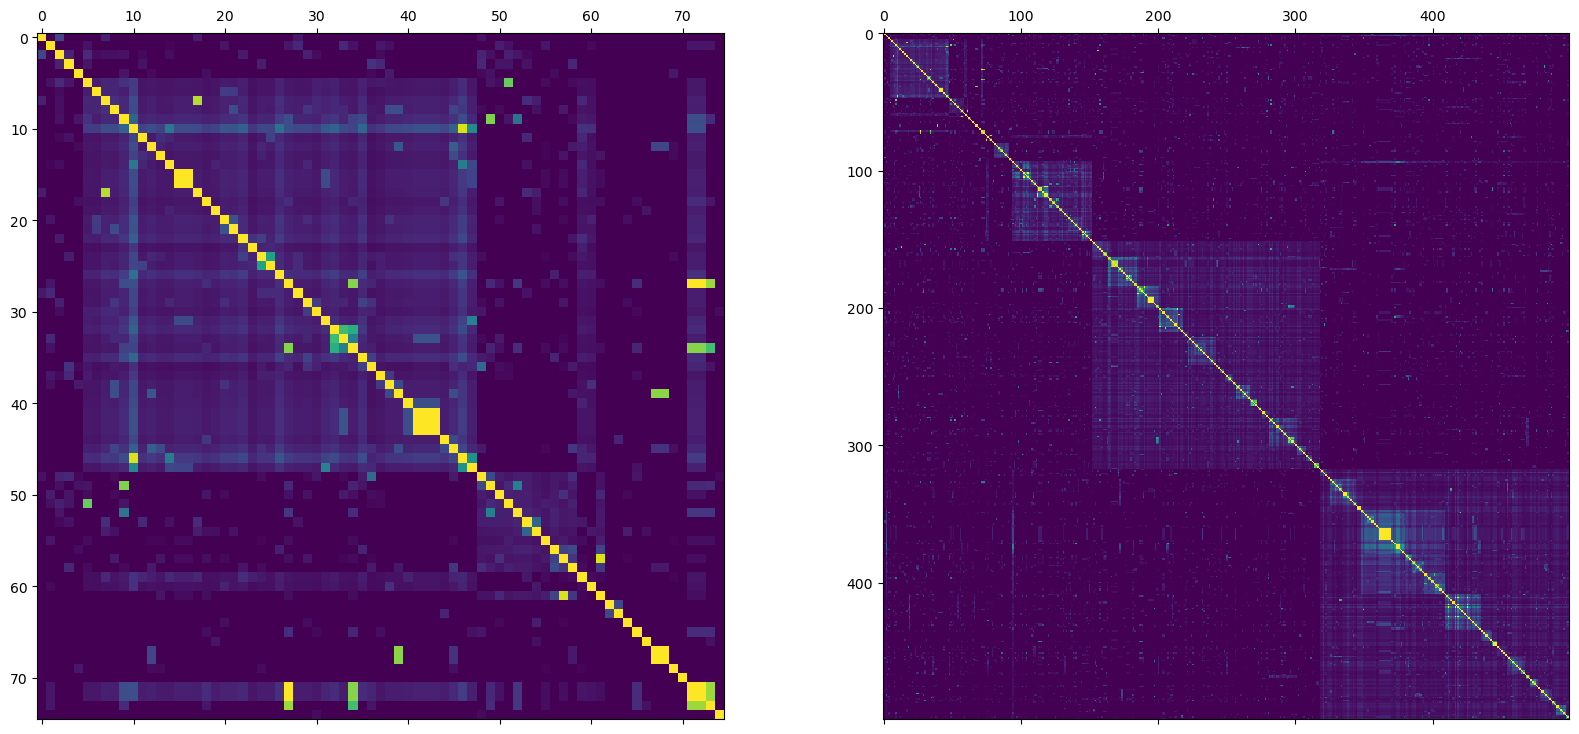

In [20]:
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams['figure.dpi'] = 100
ax1 = plt.subplot(221)
ax1.matshow(similarity_matrix_tfidf.todense()[0:75,0:75])
ax2 = plt.subplot(222)
ax2.matshow(similarity_matrix_tfidf.todense()[0:500,0:500])

An alternative visualization is to use t-sne method to represent each name in a 2D scatter plot with the distance between each element being invertly proportionnal to the corresponding similarity score. Visible clusters can already be seen in the Figure.

In [21]:
tsne_rslt = TSNE(n_components=2).fit_transform(tf_idf_matrix)

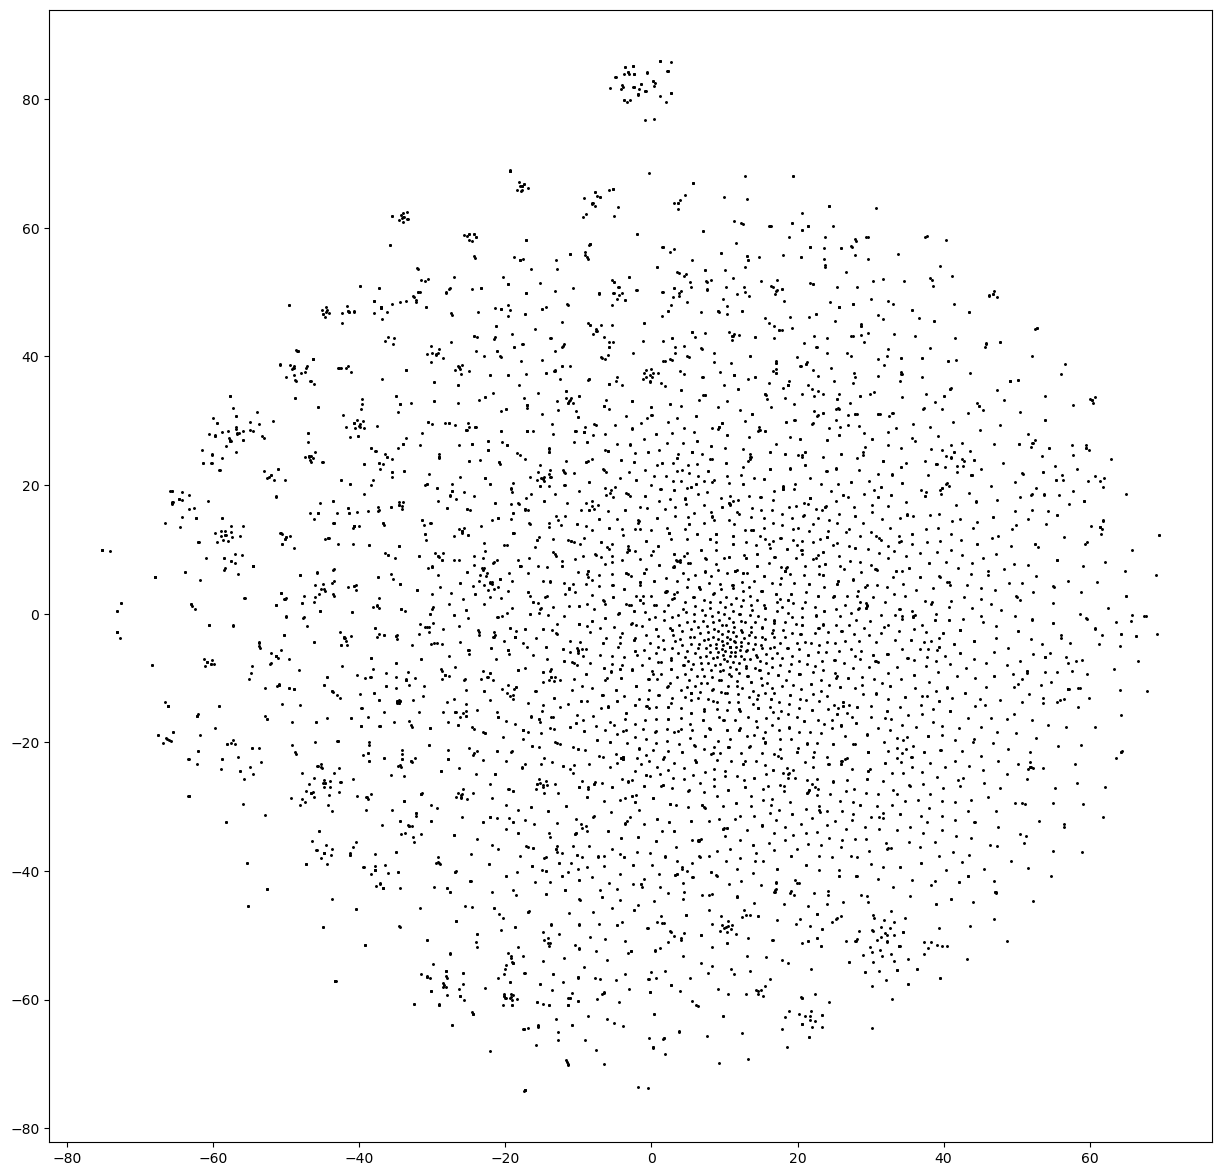

In [22]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 100
plt.scatter(tsne_rslt[:,0], tsne_rslt[:,1], c='k', s=5, marker='.')

## 5. Clustering the names 

A nice comparison of different clustering techniques and properties are available in the [sklearn documentation](https://scikit-learn.org/stable/modules/clustering.html). For our case study, the hierarchical clustering seems to be appropriate as : 1) it is supposely scalable to large number of samples and clusters$^1$, 2) we can define a distance threshold for the final clusters definition, and 3) the output can be represented as a dendrogram with different layers of clusters.  

_$1$. We will see later that this actually not totally correct for very large number of samples._

In [23]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, fcluster, leaders, leaves_list

The distance matrix (defined as the element-wise `1-similarity` operation) is first computed and will be used as input for the clustering algorithm. The resulting output is a dence matrix.

In [24]:
%%time
cosine_distances_tfidf = cosine_distances(tf_idf_matrix)

CPU times: user 202 ms, sys: 136 ms, total: 339 ms
Wall time: 529 ms


The clusterting is then performed using the scikit's `AgglomerativeClustering` class. Even if a distance threshold of `0.75` is defined, the algorithm does not stop at this distance and will continue to clusterize until there is only one cluster remaining containing all the elements. Different threshold values will later be used for the final mapping. The affinity parameter is set to `precomputed` as the distance matrix is already computed. 

One of the important hyperparameter of this clustering techniques is the linkage criteria which defined what vectors of features to use when comparing two clusters. This will define the shape of the final dendrogram (e.g. the distance between the clusters). Here, we set the linkage parameter as `complete`, meaning that the highest distance score is used as the linkage criteria. This ensure to have well-separated final clusters. 

The clustering step takes 1-2 secondes. 

In [25]:
%%time
clustering = AgglomerativeClustering(linkage='complete', affinity='precomputed', compute_distances=True,
                                     distance_threshold=0.75, n_clusters=None)
labels = clustering.fit_predict(cosine_distances_tfidf)

CPU times: user 1.24 s, sys: 49.3 ms, total: 1.29 s
Wall time: 2.47 s


The output is a list of cluster id's assigned to each element of the dataset when using the distance threshold of 0.75. Looking at the first 20 elements, we already see that the 7th element referred as `A & P - LITHOS` is clustered with the 17th referred as `A ET P - LITHOS`, and the 15th and 16th, referred as `A E PETSCHE` and `A E PETSCHE UK LIMITED` are grouped together. This confirms that the clustering is working as expected.

In [26]:
labels[0:20]

array([ 406, 1428,  343,  889,   74, 1065, 1011,  179, 1612, 1298,  663,
        370, 1473,  302,  815,   68,   68,  179,  488, 1543])

The list of all step-by-step clustering (and their element association) can be retrived directly from the clustering class. To manipulate and analyze the result of this clustering, the linkage matrix is built using all the defined links, their distance and the number of associated leaf elements. The resulting matrix is of shape (m-1,4). By definition, the clusters are sorted by their associated distance. See the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage) for more information.

In [27]:
def get_linkage(model):
    # Create linkage matrix and then plot the dendrogram

    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # Define the linkage matrix as ( link element 1, link element 2, distance, counts number  )
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    return linkage_matrix

    
linkage_matrix = get_linkage(clustering)
print(linkage_matrix.shape)
print(linkage_matrix)

(4894, 4)
[[0.000e+00 3.710e+02 0.000e+00 2.000e+00]
 [1.000e+00 1.925e+03 0.000e+00 2.000e+00]
 [3.000e+00 2.593e+03 0.000e+00 2.000e+00]
 ...
 [9.367e+03 9.785e+03 1.000e+00 4.882e+03]
 [9.334e+03 9.786e+03 1.000e+00 4.891e+03]
 [8.930e+03 9.787e+03 1.000e+00 4.895e+03]]


One way to visualize the overall clustering is to convert the cluster labels into colors in the scatter plots. We observe colored clusters. 

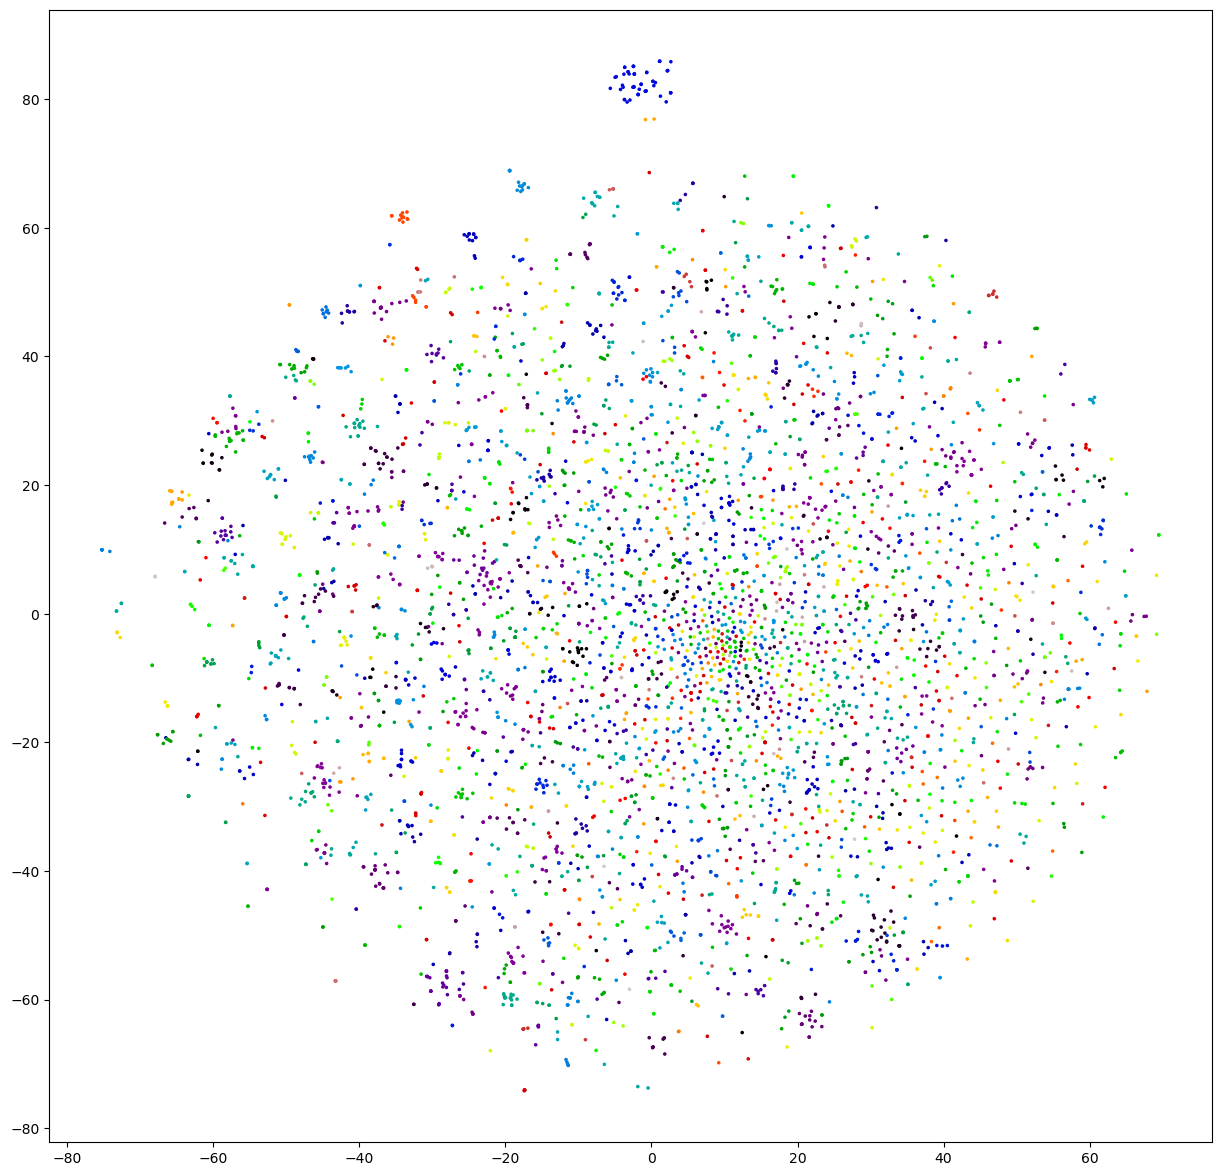

In [28]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 100
plt.scatter(tsne_rslt[:,0], tsne_rslt[:,1], c=labels, marker='.', cmap='nipy_spectral', s=10)

Another way to visalize the result of the clustering is to plot the dendrogram itself using the `scipy` tools. However, since the dataset and the resulting number of clusters are quite large, we have to use a truncated mode. This has the effect of merging the elements at close distance and of representing them as leafs in the dendrogram (with the number of merged elements shown in paranthese). So only elements and clusters with large distance from each other are represented. This shows a biased version of the outcome of the clustering algorithm. 

Below, a representation of this truncated dendrogram is shown with a threshold distance of 0.75. This means that all the links (i.e. clusters) with a distance greater than 0.75 between their elements are colored in blue. The distance between the linked elements are shown in the x axis. 

We can already observe some good clusters such the one in nrown (`EBERLEIN`) or in orange (`ATKINS`). These clusters feature elements with low distance (i.e. shifted to the right of the plot). Other bad cluster can also be observed such as the one in yellow that merged merged `AUTOVISION ZEITARBEIT` and `AUSZEIT EVENT`. They contain common letter sequences (e.g. `ZEIT`) but their corresponding elements are usually relatively distant to each others. They ended up to be clustered due to the loose distance threshold applied (0.75). A tuning of this threshold might be important as well as the need of using different threshold values for different possible association. 

/usr/lib/python3/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/lib/python3/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/lib/python3/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/lib/python3/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


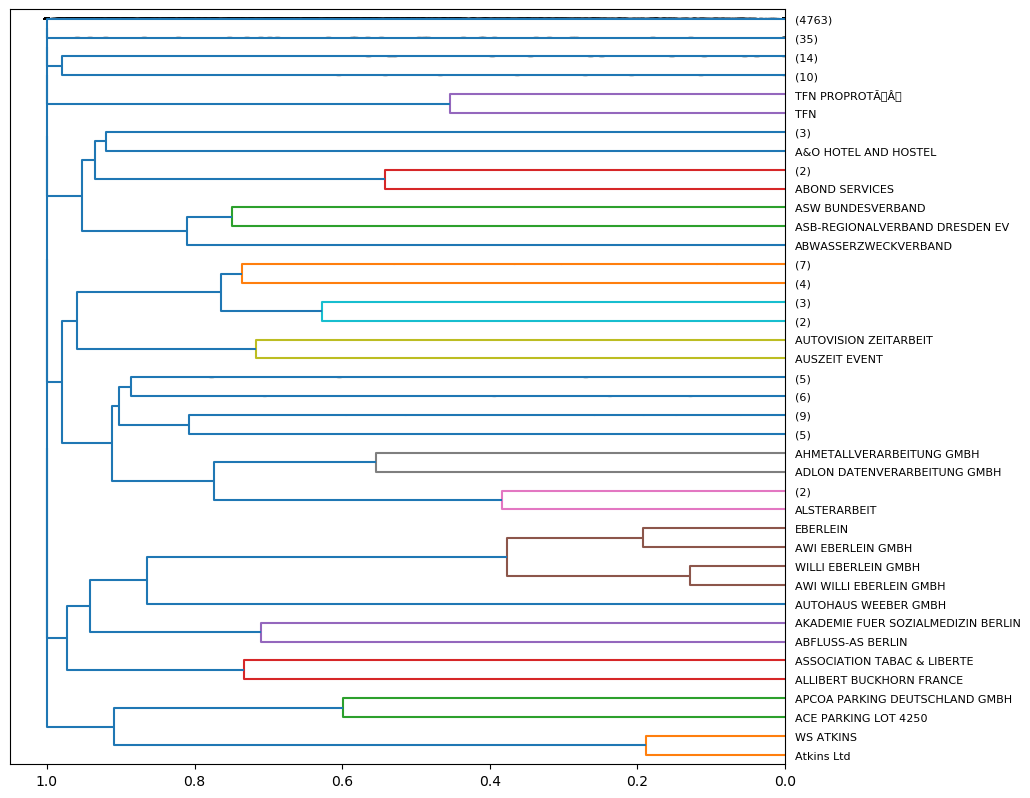

In [29]:
plt.figure(figsize=(10, 10))
dendrogram(linkage_matrix, orientation='left', p=6, truncate_mode='level', color_threshold=0.75,
           labels=data.values, show_contracted=True)
plt.show()

## 6. Mapping the names

Importing additional librairies:

In [30]:
from difflib import SequenceMatcher
from collections import Counter

Using the scipy library, the clusters are rederived using a test distance threshold of 0.5. The output is an array that map each element to its correspoding cluster id. The maximum value of this array gives the number of clusters. 

In [31]:
fclusters_test = fcluster(linkage_matrix, 0.5, criterion='distance')
print("fcluster shape: ", fclusters_test.shape)
print("Number of clusters: ", max(fclusters_test))
print("Fist cluster id: ", fclusters_test[0:20])

fcluster shape:  (4895,)
Number of clusters:  3050
Fist cluster id:  [2570 1203 1586  558  698 2757 2594  485 1806  351 3038 2537 1054 2731
 2856 1764 1764  485 2130 1666]


To evaluate the impact of the distance threshold on the clustering result, the relationship between the number of clusters and the distance threshold is plotted. The number of clusters decreases linearly between 0.5 and 1.0, while it reaches a soft saturation below 0.2. At very low distance threshold value, only very similar names are clusters, while at large distance the names with low similarity are more easily clustered together.

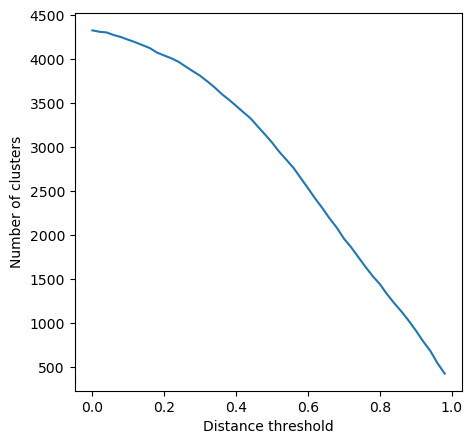

In [32]:
threshold_range = np.arange(0., 1., .02)
nclusters = [max(fcluster(linkage_matrix, t, criterion='distance')) for t in threshold_range]
plt.figure(figsize=(5, 5))
plt.plot(threshold_range, nclusters)
plt.ylabel('Number of clusters')
plt.xlabel('Distance threshold')
plt.show()

The scipy library allows to extract the leader node for each cluster, which is defined as either the link element in the linkage matrix for the clusters with more than 1 element, or as its leaf element itself for single-element clusters. 

Below, the leaders are extracted for the test threshold of 0.5. The output are two arrays of ncluster elements, which give respectively the leader nodes and their associated cluster id. 

In [33]:
leaders_nodes_test, leaders_labels_test = leaders(linkage_matrix, fclusters_test)
print(leaders_nodes_test.shape, leaders_nodes_test[0:20])
print(leaders_labels_test.shape, leaders_labels_test[0:20])

(3050,) [ 423 2702 5729 1783 3783  244 1394 4397 6242  764 1252 6268 5374 6270
 5732 5865 5637 3015 3021 5817]
(3050,) [ 2  3  1  4  5  6  7  9  8 11 12 10 13 14 16 17 15 18 21 20]


The elements of each cluster can then be extracted recursively using the leader node id. The elements of three cluster examples are shown below.

In [34]:
def get_leafs_recursively(node_id, linkage_matrix, data):
    leafs = []
    n_names = data.shape[0]
    if node_id < n_names:
        leafs.append(data.at[node_id])
    else:
        leafs += get_leafs_recursively(int(linkage_matrix[node_id-n_names,0]), linkage_matrix, data)
        leafs += get_leafs_recursively(int(linkage_matrix[node_id-n_names,1]), linkage_matrix, data)
    return leafs

In [35]:
print(get_leafs_recursively(leaders_nodes_test[8], linkage_matrix, data_clean))
print(get_leafs_recursively(leaders_nodes_test[11], linkage_matrix, data_clean))

['awi willi eberlein', 'willi eberlein', 'awi eberlein', 'eberlein']
['alsterarbeit', 'alsterarbeit ggmbh hamburg', 'alsterarbeit hamburg']


Once all the elements are extracted for each cluster, the possible names of their common entity has to be defined. Following the approach from the fuzzy matching, I decided to extract the longest common sequence from each pair of elements and counts their occurrence between all the pairs. This gives me the possibility to extract several possible entity names. 

The function below is designed to extract the three most frequent common sequences between the elements. If more than one sequences are found, they are given separated by a semicolon. The users can choose the proper entity name from the given list. If the cluster contains only one element, the name of this element is retrieved.

In [36]:
def get_common_sequences(leafs):
    leafs_length = len(leafs)
    if leafs_length > 1 :
        commong_sequences = []
        for i in range(leafs_length):
            for j in range(i+1,leafs_length):
                string1, string2 = leafs[i], leafs[j]
                match = SequenceMatcher(None, string1, string2).find_longest_match(0, len(string1), 0, len(string2))
                if match.size != 0:
                    commong_sequences.append(string1[match.a: match.a + match.size].strip())
        counts = Counter(commong_sequences)
        return ";".join([i[0] for i in counts.most_common(3)])
    else: 
        return leafs[0]

The matched names are shown for the previous examples. Several choices when different common sequences are found. The user will then be able to change the final name in the final spreadsheet.

In [37]:
print(get_common_sequences(get_leafs_recursively(leaders_nodes_test[8], linkage_matrix, data_clean)))
print(get_common_sequences(get_leafs_recursively(leaders_nodes_test[11], linkage_matrix, data_clean)))

eberlein;i eberlein;willi eberlein
alsterarbeit


The function below is used to extract a dictionary that map each cluster id to the corresponding entity names using the previous functions. This helps to extract the mapped names for each element in the final spreadsheet.  

In [38]:
def get_dict_cluster_name(fclusters, linkage_matrix, data):
    dict_cluster_name = {}
    leaders_nodes, leaders_labels = leaders(linkage_matrix, fclusters)
    for node_id, cluster_id in zip(leaders_nodes, leaders_labels):
        leafs = get_leafs_recursively(node_id, linkage_matrix, data)
        common_sequences = get_common_sequences(leafs)
        dict_cluster_name[cluster_id] = common_sequences
    return dict_cluster_name

Finally, using the approach developped above, the final clusters id and the mapped names are found for each elements of the original spreadsheet for three arbitrary-chosen distance thresholds (0.35, 0.5 and 0.65). The elements are also reordered following the dendrogram representation associated to the clustering. This ensures to have the clustered elements next to each other for all distance thresholds.

In [39]:
%%time

dfs_output = dfs.copy()

fclusters = fcluster(linkage_matrix, 0.35, criterion='distance')
dict_cluster_name = get_dict_cluster_name(fclusters, linkage_matrix, data_clean)
dfs_output["Cluster ID 0.35"] =  dfs_output.apply(lambda row: fclusters[row.name], axis=1)
dfs_output["Mapped name 0.35"] =  dfs_output.apply(lambda row: dict_cluster_name[fclusters[row.name]], axis=1)


fclusters = fcluster(linkage_matrix, 0.5, criterion='distance')
dict_cluster_name = get_dict_cluster_name(fclusters, linkage_matrix, data_clean)
dfs_output["Cluster ID 0.5"] =  dfs_output.apply(lambda row: fclusters[row.name], axis=1)
dfs_output["Mapped name 0.5"] =  dfs_output.apply(lambda row: dict_cluster_name[fclusters[row.name]], axis=1)

fclusters = fcluster(linkage_matrix, 0.65, criterion='distance')
dict_cluster_name = get_dict_cluster_name(fclusters, linkage_matrix, data_clean)
dfs_output["Cluster ID 0.65"] =  dfs_output.apply(lambda row: fclusters[row.name], axis=1)
dfs_output["Mapped name 0.65"] =  dfs_output.apply(lambda row: dict_cluster_name[fclusters[row.name]], axis=1)

names_ordered = leaves_list(linkage_matrix)
dfs_output = dfs_output.reindex(names_ordered)
display(dfs_output.head(20))

,Raw name,Cluster ID 0.35,Mapped name 0.35,Cluster ID 0.5,Mapped name 0.5,Cluster ID 0.65,Mapped name 0.65
3982,Atkins Ltd,1,atkins,1,atkins,1,atkins
4894,WS ATKINS,1,atkins,1,atkins,1,atkins
423,ACE PARKING LOT 4250,2,ace parking lot 4250,2,ace parking lot 4250,2,parking
2702,APCOA PARKING DEUTSCHLAND GMBH,3,apcoa parking,3,apcoa parking,2,parking
1783,ALLIBERT BUCKHORN FRANCE,4,allibert buckhorn,4,allibert buckhorn,3,allibert buckhorn
3783,ASSOCIATION TABAC & LIBERTE,5,tabac & liberte,5,tabac & liberte,4,tabac & liberte
244,ABFLUSS-AS BERLIN,6,abflussas berlin,6,abflussas berlin,5,abflussas berlin
1394,AKADEMIE FUER SOZIALMEDIZIN BERLIN,7,fuer sozialmedizin berlin,7,fuer sozialmedizin berlin,6,fuer sozialmedizin berlin
4397,AUTOHAUS WEEBER GMBH,10,weeber,9,weeber,8,weeber
4675,AWI WILLI EBERLEIN GMBH,8,willi eberlein,8,eberlein;i eberlein;willi eberlein,7,eberlein;i eberlein;willi eberlein


CPU times: user 1.42 s, sys: 0 ns, total: 1.42 s
Wall time: 3.28 s


The left-most columns contains the most conservative clustering with small clusters containing very similar elements, while the right-most columns shows the most aggressive clustering with larger clusters containing more distant elements. The user can then decide which layer to use for each element. For instance, the clustering at 0.5 and 0.65 seems more appropriate for the `EBERLEIN` elements, while the the distance 0.35 and 0.5 seems better to keep the different `parking` names into different clusters. In general, different threshold can be approriate for certain type of elements but not for other elements. More layers can be added as well as different distance threshold values.

## 7. Evaluating the performance

### 7.1 Performance/Accuracy

To evaluate the performance of the overall algorithm in an unbiased way, I performed an error analysis on 20 randomly-chosen names shown below. For each name, I checked if they are corretly clustered to names from similar entity. I also looked for other possible similar names that could have been wrongly clustered to other names. 

In [40]:
dfs_output.sample(20, random_state = 123)

,Raw name,Cluster ID 0.35,Mapped name 0.35,Cluster ID 0.5,Mapped name 0.5,Cluster ID 0.65,Mapped name 0.65
1058,AFPI PAYS DE LA LOIRE,2765,afpi pays de l,2300,afpi pays de l,1650,afpi pays de l
1382,AKADEMIE F SEKRETARIAT UND,3271,f sekretariat und,2725,sekretariat und;r sekretariat und b,1970,sekretariat und;r sekretariat und b
784,ADOBE SYSTEMS INCORPORATED,2119,adobe,1747,adobe;adobe ireland,1244,adobe;adobe ireland
2266,AMICALE JEAN-BAPTISTE SALIS,1032,baptiste salis,854,baptiste salis,596,baptiste salis
1464,AKTOR INTERACTIVE,3535,aktor interactive,2954,aktor interactive,2154,aktor;aktor interactive
1762,ALLIANCE FRANCAISE,2952,alliance francaise,2450,alliance francaise,1755,francaise;e francaise;alliance francaise
1826,ALM FAMILIE ROHRMOSER,3550,alm familie rohrmoser,2968,alm familie rohrmoser,2166,alm familie rohrmoser
3561,ASOC ALIANZA ESPANOLA EN GRAFENO,2882,asoc alianza espanola en grafeno,2393,asoc alianza espanola en grafeno,1709,espanola;asoc atlantica espa;a espanola
1652,ALGITECH,2825,algitech,2349,algitech,1684,gite
3749,ASSOCIATION LE CLUB TOP 20,2940,le club top 20,2440,le club top 20,1746,le club top 20


The result is quite promising. 90% of the names (i.e. 18) are correctly clustered. A few examples are shown below for the `ADOBE` and `AVNET` cases. Both of these examples show very good clusters for one of the cluster layers and good mapped names. 

In [41]:
dfs_output[2867:2879]

,Raw name,Cluster ID 0.35,Mapped name 0.35,Cluster ID 0.5,Mapped name 0.5,Cluster ID 0.65,Mapped name 0.65
1206,AGSE,2117,agse,1745,agse,1243,gse
4339,AUTOHAUS GSER GMBH & CO KG,2118,gser,1746,gser,1243,gse
784,ADOBE SYSTEMS INCORPORATED,2119,adobe,1747,adobe;adobe ireland,1244,adobe;adobe ireland
783,ADOBE SYSTEMS,2119,adobe,1747,adobe;adobe ireland,1244,adobe;adobe ireland
781,ADOBE,2119,adobe,1747,adobe;adobe ireland,1244,adobe;adobe ireland
782,ADOBE INC,2119,adobe,1747,adobe;adobe ireland,1244,adobe;adobe ireland
785,ADOBE SYSTEMS SOFTWARE IRELAND,2120,adobe ireland,1747,adobe;adobe ireland,1244,adobe;adobe ireland
786,ADOBE SYSTEMS SOFTWARE IRELAND LIMI,2120,adobe ireland,1747,adobe;adobe ireland,1244,adobe;adobe ireland
3841,ASV STUEBBE GMBH UND CO KG,2121,asv stuebbe und,1748,asv stuebbe und,1245,ebbe
4335,AUTOHAUS FLEBBE GMBH,2122,flebbe,1749,flebbe,1245,ebbe


In [42]:
dfs_output[1861:1872]

,Raw name,Cluster ID 0.35,Mapped name 0.35,Cluster ID 0.5,Mapped name 0.5,Cluster ID 0.65,Mapped name 0.65
4648,AVS AHLHEIM,1341,avs ahlheim,1090,avs ahlheim,762,avs
4649,AVS ROEMER GMBH,1342,avs roemer,1091,avs roemer,762,avs
4622,AVNET EUROPE COMMVA,1346,avnet commva,1095,avnet commva,763,avnet
4620,AVNET ABACUS,1345,avnet abacus,1094,avnet abacus,763,avnet
4623,AVNET SILICA,1344,avnet silica,1093,avnet silica,763,avnet
4619,AVNET,1343,avnet,1092,avnet,763,avnet
4621,AVNET EMG GMBH,1343,avnet,1092,avnet,763,avnet
4614,AVL LIST GMBH,1347,avl list,1096,avl list,764,avl
4615,AVL SCHRICK GMBH,1348,avl schrick,1097,avl schrick,764,avl
4652,AVTRADE LIMITED,1349,avtrade,1098,avtrade,765,avtrade


Below, the examples given in the case study's instructions are also shown.

In [43]:
display(dfs_output[1998:2004])
display(dfs_output[3854:3863])
display(dfs_output[1426:1430])

,Raw name,Cluster ID 0.35,Mapped name 0.35,Cluster ID 0.5,Mapped name 0.5,Cluster ID 0.65,Mapped name 0.65
1911,ALS LIFE SCIENCES LTD,1447,als life sciences,1184,als life sciences,829,life;als life sciences
1980,ALTER TECHNOLOGY,1451,alter,1187,alter;alteryx,831,alter;alteryx
1992,ALTERYX,1450,alteryx,1187,alter;alteryx,831,alter;alteryx
1993,"ALTERYX, INC",1450,alteryx,1187,alter;alteryx,831,alter;alteryx
1986,ALTERNANCE ACADEMY,1452,alternance academy,1188,alternance,832,alternance
1987,ALTERNANCE FORMATION,1453,alternance formation,1188,alternance,832,alternance


,Raw name,Cluster ID 0.35,Mapped name 0.35,Cluster ID 0.5,Mapped name 0.5,Cluster ID 0.65,Mapped name 0.65
3616,ASOCIACION PRL INNOVACION,2862,prl innovacion,2377,prl innovacion,1699,innovac
2037,ALTRAN INNOVACION SOCIEDAD LIMITADA,2864,altran innovacion sociedad limitada,2379,altran innovacion sociedad limitada,1700,altran innovaci;altran innovacion;altran innov...
2031,ALTRAN INNOVACIÃÂN S.L.,2863,altran innovaci;altran innovacion;altran innov...,2378,altran innovaci;altran innovacion;altran innov...,1700,altran innovaci;altran innovacion;altran innov...
2032,"ALTRAN INNOVACIÃÂN, S.L.U",2863,altran innovaci;altran innovacion;altran innov...,2378,altran innovaci;altran innovacion;altran innov...,1700,altran innovaci;altran innovacion;altran innov...
2033,ALTRAN INNOVACION S.L.,2863,altran innovaci;altran innovacion;altran innov...,2378,altran innovaci;altran innovacion;altran innov...,1700,altran innovaci;altran innovacion;altran innov...
2035,ALTRAN INNOVACION SL,2863,altran innovaci;altran innovacion;altran innov...,2378,altran innovaci;altran innovacion;altran innov...,1700,altran innovaci;altran innovacion;altran innov...
2034,ALTRAN INNOVACION S.L.U.,2863,altran innovaci;altran innovacion;altran innov...,2378,altran innovaci;altran innovacion;altran innov...,1700,altran innovaci;altran innovacion;altran innov...
2036,ALTRAN INNOVACION SLU,2863,altran innovaci;altran innovacion;altran innov...,2378,altran innovaci;altran innovacion;altran innov...,1700,altran innovaci;altran innovacion;altran innov...
3776,ASSOCIATION RUGBYSTIQUE,2870,rugbystique,2382,rugbystique,1702,rugbystique


,Raw name,Cluster ID 0.35,Mapped name 0.35,Cluster ID 0.5,Mapped name 0.5,Cluster ID 0.65,Mapped name 0.65
2374,ANAFORA,1031,anafora,853,anafora,595,anafora
2265,AMICALE JEAN BAPTISTE SALIS,1032,baptiste salis,854,baptiste salis,596,baptiste salis
2266,AMICALE JEAN-BAPTISTE SALIS,1032,baptiste salis,854,baptiste salis,596,baptiste salis
2264,AMICALE DU PERSONNEL DE LA BASE,1033,amicale du personnel de la base,855,amicale du personnel de la base,597,amicale du personnel de la base


From the 20 randomly-chosen examples, two names showed an issue. First, the `AFPI PAYS DE LA LOIRE` name show that the mapped name can sometimes be inacurrate due to missing characters or words between the clustered names. This is however not an important issue as the user can easily change the name in the final spreadsheet. 

The other error is coming from the `ARTELIA` name. Even if this name was correctly clustered to similar names, I found other `ARTELIA`-related names like `ARTELIA VILLE & TRANSPORT` that were wrongly clustered to other `TRANSPORT`-related names. This shows a flaw in the algorithm coming from the presence of recurrent terms that were not filtered-out during the data pre-processing and that reduces the performance of the clustering. A similar issue was found for a significant proportion of the names for a previous version of the algorithm when a less aggressive data pre-processing was performed. This was solved by using a much larger set of stop-words. A similar solution can also be done here, i.e. by adding the word `transport` as an additional stop-word. In general, the choice of the list of stop-word is quite important for the overall performance of the clustering algorithm. 

Even if the overall performance of the algorithm is relative good, this error analysis was however performed on a low-stat sample, consisting mainly of single-element clusters. This overall performance can simply be a coincidince. Performing an error analysis on a larger dataset would allow to confirm it and would give a better idea of the most recurrent errors from the algorithm.

### 7.2 Scalability to larger dataset

The full algorithm was written in a separate python file and can be called using the following librairy.

In [44]:
from name_mapping import name_mapping

To evaluate the speed of the algorithm, the time of the name mapping is evaluated. In general, the algorithm takes between 3 and 4 seconds, which is quite reasonable. 

In [62]:
%time dfs_output_5k = name_mapping(dfs, "Raw name")

Pre-processing the data...
Clustering...
Mapping using a threshold distance of 0.35 ...
Mapping using a threshold distance of 0.5 ...
Mapping using a threshold distance of 0.65 ...
Re-ordering the data...
CPU times: user 3.68 s, sys: 438 ms, total: 4.12 s
Wall time: 5.47 s


To confirm the ability to run on a larger dataset, the current data set is duplicated 21 times (resulting into more than 100k names). Two of the letters from each names are also swapped, which simulates the clusters. 

In [63]:
from random import randint, sample
def swap_letters_random(name):
    if len(name) < 3 : return name
    i = randint(1, len(name)-2)
    l = list(name)
    l[i], l[i+1] = l[i+1], l[i]
    return "".join(l)

In [64]:
swap_letters_random("test")

'tets'

In [66]:
dfs_long = dfs.copy()
dfs_long = pd.concat([dfs_long]*21, ignore_index=True)
dfs_long["Raw name"] = dfs_long["Raw name"].apply(swap_letters_random)
print(len(dfs_long))
display(dfs_long.head(10))

102795


,Raw name
0,"""ACCESOS NORMALIZAODS, SL"""
1,"""ALTAIX ELECTRONICA , S.AL.."""
2,"""ANTALA LOCKS & ACCESROIS, SL"""
3,"""ANTERAL, LS"""
4,"""ARQUIMEA INGENIERIA, S.L."""
5,A &D ENVIRONMENTAL SERVICES LTD
6,A &L GOODBODY
7,A & P -L ITHOS
8,A & T STATIONERS PRIVATE LIMIETD
9,A A LOIGSTIK-EQUIPMENT


Running the algorithm for this large dataset...

In [67]:
dfs_output_long = name_mapping(dfs_long, "Raw name")

Pre-processing the data...
Clustering...


MemoryError: Unable to allocate array with shape (1679268408,) and data type float64

Unfortunately, the algorithm fails after a few seconds on the clustering step. This is coming from the computation of the distance matrix which takes too much memory due to the large number of considered pair of names. To be honest, I badly anticipated this issue when designing this algorithm, even though this is not a surprising problem for large number of samples and features. 

After spending several hours of researching for possible solutions, I still have no reliable tricks to overcome this problem. It seems that the hierarchical clustering in sklearn is not designed to work on sparse matrices which is an essential object for our problem as this allows to reduce the amount of memory to store the feature values and the distance scores between the element of the datasets. When the dense matrices are considered, the amount of ram memory becomes too important. So far, I haven't found any workaround to deal with this problem. Further research is needed.

## 8. How to go further

The main feature of the algorithm to improve is obviously its scability for larger dataset which is currently not supported with the current version of this algorithm. One possible solution is to use a different hierarchical clustering algorithm which supports the use of sparse matrices. The [HBDSCAN clustering](https://hdbscan.readthedocs.io/en/latest/index.html) is an example. It was shown to be a faster clustering technique compared the sklearn Agglomerative clustering implementation (see [this study](https://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html)). Though, it is not clear this technique works well for our situation where the datasets contains many clusters. This has to be tested. 

Once this issue is solved, the algorithm can be furter improve by doing a more detailed error analysis in order to analyze the most recurrent flaws of the current solution. Possibly, the list of stop-words will have to be improved in order to improve the performance of the clustering. In addition, I have also noticed that the cleanco librairy performs a quite aggressive cleaning which sometimes completely empty the string from any characters. A better tuning of this cleaning is probably needed too.